one hot embedding

A variant of one-hot encoding os the so-called hashing trick, 
which you can use when the number of unique tokens in your vocabulary is too large to handle explicitly.
Instead of explicitly assign an index to each word and keeping a reference to these indices in a dictionary,
you can hash words into vectors of fixed size.

word embedding

There are two ways to obtain word embeddings:

Learn word embeddings jointly with the main task you care about. 
In this setup, you start with random word vectors and then learn word vectors in the same way 
you learn the weights of a neural network.

Load into your model word embeddings that were precomputed using a different machine-learning task 
than the one you're trying to solve.
These are called pretrained word embeddings.

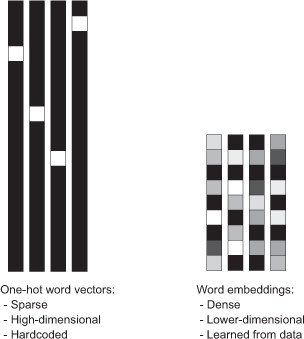

In [1]:
# Loading the IMDB data for use with an Embedding layer

from keras.datasets import imdb
from keras.utils.data_utils import pad_sequences 


max_features = 10000
maxlen = 20
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [2]:
# Using an Embedding layer and classifier on the IMDB data

from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding


model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 8)             80000     
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 1)                 161       
                                                                 
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


2022-08-11 16:13:29.188354: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-11 16:13:29.191015: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


625/625 [==============================] - 1s 2ms/step - loss: 0.6791 - acc: 0.5911 - val_loss: 0.6409 - val_acc: 0.6872
Epoch 2/10
625/625 [==============================] - 1s 1ms/step - loss: 0.5609 - acc: 0.7432 - val_loss: 0.5343 - val_acc: 0.7210
Epoch 3/10
625/625 [==============================] - 1s 1ms/step - loss: 0.4684 - acc: 0.7847 - val_loss: 0.5015 - val_acc: 0.7460
Epoch 4/10
625/625 [==============================] - 1s 1ms/step - loss: 0.4255 - acc: 0.8068 - val_loss: 0.4930 - val_acc: 0.7536
Epoch 5/10
625/625 [==============================] - 1s 1ms/step - loss: 0.3975 - acc: 0.8205 - val_loss: 0.4919 - val_acc: 0.7574
Epoch 6/10
625/625 [==============================] - 1s 1ms/step - loss: 0.3755 - acc: 0.8336 - val_loss: 0.4930 - val_acc: 0.7564
Epoch 7/10
625/625 [==============================] - 1s 1ms/step - loss: 0.3561 - acc: 0.8467 - val_loss: 0.4967 - val_acc: 0.7598
Epoch 8/10
625/625 [==============================] - 1s 1ms/step - loss: 0.3383 - acc:

In [3]:
# Putting it all together

import os
import csv


imdb_dataset = '/root/workspace/ml/imdb_dataset/imdb_dataset.csv'


labels = []
texts = []
with open(imdb_dataset) as fin:
    reader = csv.reader(fin)
    next(reader)
    for fields in reader:
        text, label = fields
        texts.append(text)
        labels.append(1 if label == 'positive' else 0)

In [4]:
# Tokenizing the data

from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
import numpy as np


maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples : training_samples + validation_samples]
y_val = labels[training_samples : training_samples + validation_samples]

Found 124252 unique tokens.
Shape of data tensor: (50000, 100)
Shape of label tensor: (50000,)


In [5]:
glove_dir = '/root/workspace/ml/glove'
embeddings_index = {}
with open(os.path.join(glove_dir, 'glove.6B.100d.txt')) as fin:
    for line in fin:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [6]:
# Preparing the GloVe word-embeddings matrix

embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [7]:
# Model definition

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense


model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_1 (Dense)             (None, 32)                320032    
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Loading the GloVe embeddings in the model

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [9]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('imdb_dataset/pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 9s 1s/step - loss: 1.6174 - acc: 0.5800 - val_loss: 0.8404 - val_acc: 0.4985
Epoch 2/10
7/7 [==============================] - 9s 1s/step - loss: 0.7167 - acc: 0.6850 - val_loss: 0.7456 - val_acc: 0.5186
Epoch 3/10
7/7 [==============================] - 9s 2s/step - loss: 0.3389 - acc: 0.8800 - val_loss: 0.8918 - val_acc: 0.5105
Epoch 4/10
7/7 [==============================] - 8s 1s/step - loss: 0.1934 - acc: 0.9700 - val_loss: 0.8091 - val_acc: 0.5141
Epoch 5/10
7/7 [==============================] - 9s 1s/step - loss: 0.1568 - acc: 0.9750 - val_loss: 0.7629 - val_acc: 0.5384
Epoch 6/10
7/7 [==============================] - 9s 2s/step - loss: 0.3857 - acc: 0.8100 - val_loss: 0.8470 - val_acc: 0.5234
Epoch 7/10
7/7 [==============================] - 9s 1s/step - loss: 0.0684 - acc: 1.0000 - val_loss: 0.8033 - val_acc: 0.5391
Epoch 8/10
7/7 [==============================] - 7s 1s/step - loss: 0.0390 - acc: 1.0000 - val_loss: 0.8422 - 

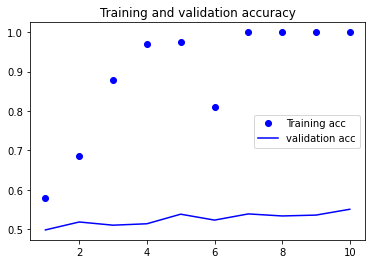

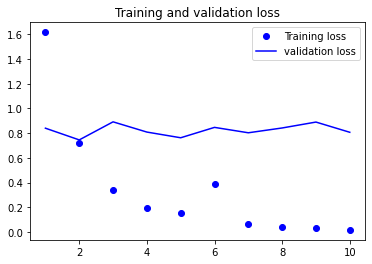

In [10]:
import matplotlib.pyplot as plt


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()